# Functionalizing prototype

In [1]:
from os.path import abspath
from sys import path
path.insert(0, abspath("../.."))  # Repository directory relative to this file.
from MISalign.model.mis_file import MisFile,load_mis

mis_fp=r"..\..\example\data\set_a\mymis.mis"
mp=load_mis(mis_fp)

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image as PILImage

In [2]:
rect_rels=mp.get_rels('r')
display(rect_rels)
print(rect_rels[0])

[[('a_myimages01.jpg', 'a_myimages02.jpg'), (12, -1088)],
 [('a_myimages02.jpg', 'a_myimages03.jpg'), (8, -1141)],
 [('a_myimages03.jpg', 'a_myimages04.jpg'), (-129, -1058)],
 [('a_myimages04.jpg', 'a_myimages05.jpg'), (11, -943)],
 [('a_myimages05.jpg', 'a_myimages06.jpg'), (5, -860)],
 [('a_myimages06.jpg', 'a_myimages07.jpg'), (10, -990)],
 [('a_myimages07.jpg', 'a_myimages08.jpg'), (9, -1009)],
 [('a_myimages08.jpg', 'a_myimages09.jpg'), (9, -939)],
 [('a_myimages09.jpg', 'a_myimages10.jpg'), (3, -722)]]

[('a_myimages01.jpg', 'a_myimages02.jpg'), (12, -1088)]


In [27]:
def _metric_function(difference_array)->float:
    pass

def axis_span(OVn:int,an_max:int,bn_max:int):
    """Takes the offset vector of axis n, image a max value for axis n, and image b max value for axis n. Returns image a and image b overlap spans for axis n."""
    if OVn==0:
        an_span=(0,min(an_max,bn_max))
        bn_span=(0,min(an_max,bn_max))
    elif OVn > 0:
        an_span=(0,an_max-OVn)
        bn_span=(OVn,an_max)
    elif OVn < 0:
        an_span=(-OVn,bn_max)
        bn_span=(0,bn_max+OVn)
    else:
        ValueError()
    return an_span,bn_span

def overlap_spans(offset_vector:tuple,a_shape:tuple,b_shape:tuple):
    """Takes an offset vector and shape of image a and image b. Returns the overlapping spans."""
    if not all([offset_vector[0]>-b_shape[0],offset_vector[0]<a_shape[0],offset_vector[1]>-b_shape[1],offset_vector[1]<a_shape[1]]):
        ValueError("These images do not overlap")
    ax_span,bx_span=axis_span(offset_vector[0],a_shape[1],b_shape[1])
    ay_span,by_span=axis_span(offset_vector[1],a_shape[0],b_shape[0])
    return (ax_span,ay_span),(bx_span,by_span)

def difference_compare(
        image_a_arr:np.ndarray,
        image_b_arr:np.ndarray,
        offset_ab:tuple,
        metric:[str,_metric_function],
        return_difference=False)->float:
    """Compares difference of Image A and Image B using specified A-to-B relation and comparison metric.
    - `image_a` and `image_b` are numpy arrays from PIL images converted to type `int`
    - `offset_ab` is an (x,y) offset pair as generated by `MisFile.get_rels('r')`
    - `metric` can be either a string referencing a built-in metric(`diff_abs_mean`,`diff_squared_mean`) or a function of the form `metric_function(difference_array)->float`
    - Returns a float value representing the difference according to the metric
    - `return_difference` changes output to (difference_value,difference_array)
    """
    ## Find overlap spans
    a_spans,b_spans=overlap_spans(offset_ab,image_a_arr.shape,image_b_arr.shape)
    ## Take difference of overlaps
    difference_array=image_a_arr[a_spans[1][0]:a_spans[1][1],a_spans[0][0]:a_spans[0][1]] - image_b_arr[b_spans[1][0]:b_spans[1][1],b_spans[0][0]:b_spans[0][1]]
    ## Get difference metric
    if type(metric) is str:
        if metric=="diff_squared_mean":
            metric_function=lambda diff_arr: np.mean(diff_arr**2)
        elif metric=="diff_abs_mean":
            metric_function=lambda diff_arr: np.mean(np.abs(diff_arr))
    else:
        metric_function=metric
    difference_metric=metric_function(difference_array)
    ## Return of values
    if return_difference:
        return difference_metric, difference_array
    else:
        # plt.figure()
        # plt.imshow(np.abs(difference_array))
        return difference_metric
def difference_gradient_analysis(
        mp:MisFile,
        relation_ab,
        strategy="full_grid",
        strategy_max=5,
        metric="diff_squared_mean",
        )->dict:
    """Compares differences of Images at multiple offsets to identify the best offset.
    - `strategy` includes `full_grid`, `local_minima`, and `gaussian_minimization`.
        - `full_grid` - search is performed from `relation`-`strategy_max` to `relation`+`strategy_max` > example: `strategy_max=3` will search a 7x7 offset space around the current offset.
        - TODO - `local_minima` - search starts with +1/-1 around `relation` and then moves to the observed minima and another +1/-1 is searched until a local minima is found.
        - TODO - `gaussian_minimization` - gaussian process regression is used to fit the minimization trend and efficiently reach the minimum value.
    - `metric` is pass-through parameter to `difference_compare`
    """
    ## Open images
    image_a=PILImage.open(mp.get_image_paths()[relation_ab[0][0]])
    image_a_arr=np.array(image_a).astype(int)
    image_b=PILImage.open(mp.get_image_paths()[relation_ab[0][1]])
    image_b_arr=np.array(image_b).astype(int)
    ## `full_grid` strategy
    if strategy=="full_grid":
        grid_shape=(1+strategy_max*2,1+strategy_max*2)
        grid=np.fromfunction(lambda x,y: np.array([x-strategy_max,y-strategy_max]),shape=grid_shape,dtype=int)
        grid_results=np.full(grid_shape,np.nan)
        grid_indeces=np.fromfunction(lambda x,y: np.array([x,y]),shape=grid_shape,dtype=int).reshape(2,-1)

        for i,grid_index in enumerate(grid_indeces.T):
            check_offset_grid_shift=grid[:,grid_index[0],grid_index[1]]
            check_offset=relation_ab[1]+check_offset_grid_shift
            # print(i,grid_index)
            # print(i,grid[:,grid_index[0],grid_index[1]])
            # print(check_offset)
            grid_results[grid_index[0],grid_index[1]]=difference_compare(image_a_arr,image_b_arr,
                offset_ab=check_offset,
                metric=metric)
    ## Return values
    return {"grid_results":grid_results}

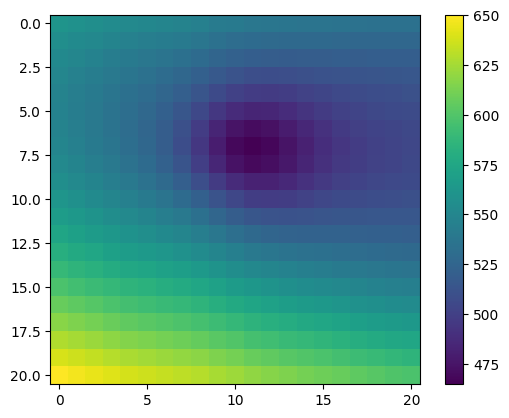

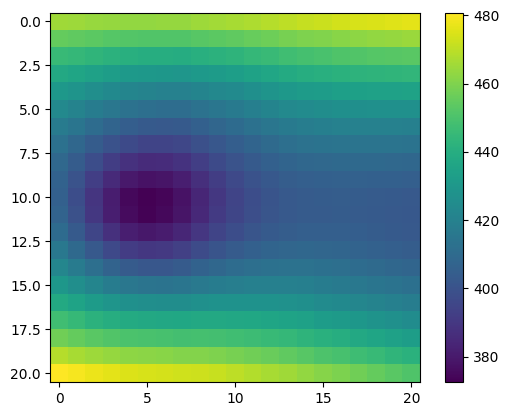

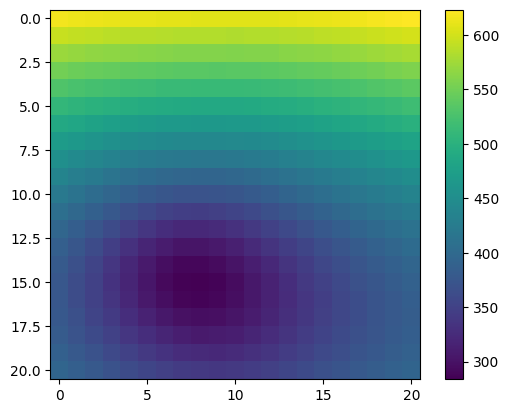

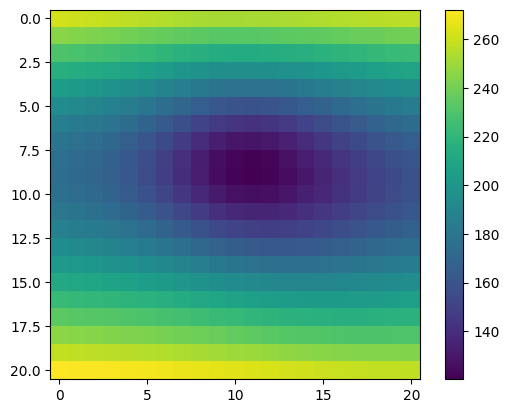

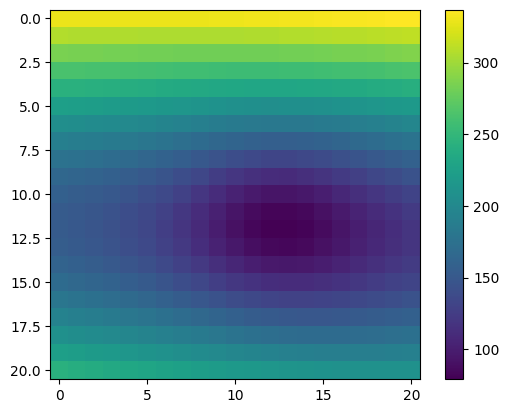

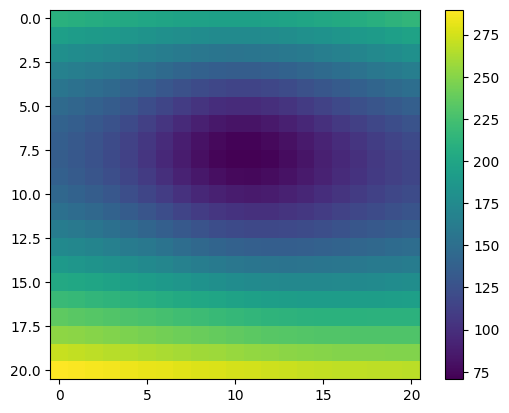

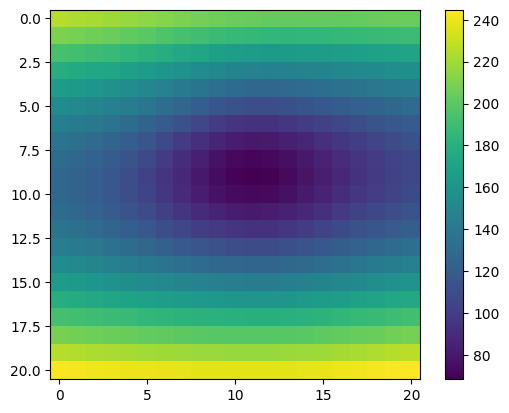

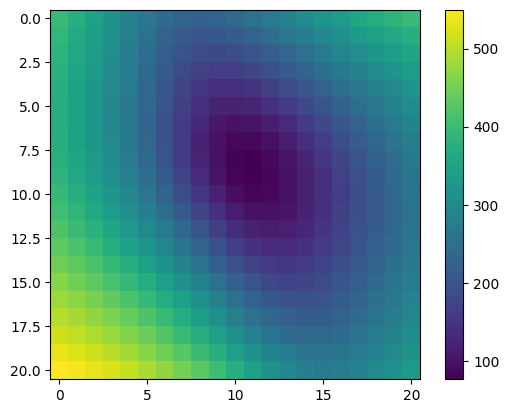

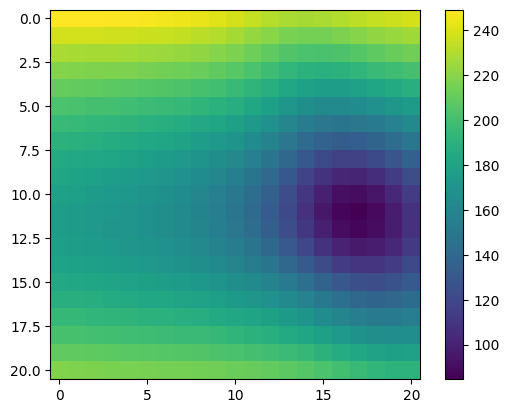

In [28]:
for rel in rect_rels:
    dga_results=difference_gradient_analysis(
        mp=mp,
        relation_ab=rel,
        strategy="full_grid",
        strategy_max=10,
        metric="diff_squared_mean"
        )
    plt.figure()
    plt.imshow(dga_results["grid_results"])
    plt.colorbar()
    plt.show()
